In [1]:
# pip install -U pip setuptools wheel
# pip install -U spacy
# python -m spacy download en_core_web_trf

import regex, os, sys
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from ThoughtGraph import utils

DATA_FILE = 'dolly_data_paraphrase-MiniLM-L6-v2.parquet' # 'dolly_data_all-mpnet-base-v2.parquet'

POS_DATA_FILE = 'dolly_data_pos.parquet'


In [2]:
if os.path.exists(POS_DATA_FILE):
    dolly_data = pd.read_parquet(POS_DATA_FILE)
else:
    dolly_data = pd.read_parquet(DATA_FILE).rename(columns={
        'inst_A':'instruction_A', 'inst_B':'instruction_B',
        'resp_A':'response_A', 'resp_B': 'response_B',
    })
    
    dolly_data['category'] = ['open_qa' if cat == 'general_qa' else cat for cat in dolly_data['category'] ]

    dolly_data['instruction_pos'] = utils.text_to_pos(dolly_data['instruction'], parsify_attributes=['pos_'])
    dolly_data.to_parquet(POS_DATA_FILE)
    

In [3]:
dolly_data[['instruction', 'instruction_pos']]

,instruction,instruction_pos
10398,What is the difference between a sitar and a t...,pron aux det noun adp det noun cconj det noun ...
6297,"What other names are used to refer to Taweret,...",det adj noun aux verb part verb adp propn punc...
7594,Which clef does a viola use?,det noun aux det noun verb punct
19,Identify which instrument is string or percuss...,verb det noun aux noun cconj noun punct propn ...
27,Identify which instrument is string or woodwin...,verb det noun aux noun cconj noun punct propn ...
...,...,...
3456,Please describe a fantasy animal,intj verb det noun noun
6894,Do you know the species Etlingera diepenhorstii,aux pron verb det noun propn noun
9076,Where is Dieveniskes located,sconj aux propn verb
957,"How are the characters Balrog, Vega and M. Bis...",sconj aux det noun propn punct propn cconj pro...


# POS N_gram counts

In [4]:
import regex, os, sys
import numpy as np
import pandas as pd
from collections import Counter
from sklearn import metrics

from utils import utils

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
pos_count_vect = CountVectorizer( ngram_range=(4,12), min_df=25, stop_words=None)
instruction_pos_ngram_counts_matrix = pos_count_vect.fit_transform(dolly_data['instruction_pos'])
# instruction_pos_ngram_counts_matrix.shape

instruction_pos_ngram_counts_pdf = pd.DataFrame(data = instruction_pos_ngram_counts_matrix.todense(), columns = pos_count_vect.get_feature_names_out())
# HTML( instruction_ngram_counts_pdf[1:100].to_html() )

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

pos_tfidf_matrix = TfidfTransformer().fit_transform(instruction_pos_ngram_counts_matrix)

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pos_tfidf_matrix_r = pca.fit_transform(np.asarray(pos_tfidf_matrix.todense()))
pos_tfidf_matrix_r.shape  # (15011, 200)


(15011, 100)

In [8]:
dolly_data['pos_tfidf_PCs'] = pos_tfidf_matrix_r.tolist()

dolly_data2 = utils.add_cluster_cols(dolly_data, embedding_col='pos_tfidf_PCs', prefix='pos_', letters='ABCDEF', max_threshold=16)

### BUG ALERT! Prefix has to end in underscore, and the resulting columns have double underscores.

In [9]:
dolly_data2.columns

Index(['instruction', 'context', 'response', 'category', 'has_context',
       'instruction_vector', 'response_vector', 'instruction_A',
       'instruction_B', 'response_A', 'response_B', 'instruction_pos',
       'pos_tfidf_PCs', 'pos__A', 'pos__B', 'pos__C', 'pos__D', 'pos__E',
       'pos__F'],
      dtype='object')

In [10]:
cluster_col = 'pos__A'
# Counter(dolly_data2['pos__A'])

pos_xtab = pd.crosstab(dolly_data2[cluster_col], dolly_data2['category'])
pos_xtab  # raw counts

category,brainstorming,classification,closed_qa,creative_writing,information_extraction,open_qa,summarization
pos__A,,,,,,,
pos__A1,181,44,126,74,90,614,115
pos__A2,6,546,8,0,2,25,1
pos__A3,0,281,1,0,0,7,0
pos__A4,2,413,4,1,2,7,2
pos__A5,261,25,118,133,91,695,121
pos__A6,384,81,415,152,331,586,233
pos__A7,110,176,259,69,150,923,128
pos__A8,1,1,63,1,52,128,62
pos__A9,821,569,779,279,788,2948,526


In [11]:
Counter(dolly_data2['category']).most_common()

[('open_qa', 5933),
 ('classification', 2136),
 ('closed_qa', 1773),
 ('brainstorming', 1766),
 ('information_extraction', 1506),
 ('summarization', 1188),
 ('creative_writing', 709)]

In [12]:
pos_cluster_cols = [col for col in dolly_data2.columns if col.startswith('pos__')]

filtered_paths = utils.filter_cluster_paths(dolly_data2, pos_cluster_cols)

filtered_paths

[['pos__A2', 'pos__C010', 'pos__D019', 'pos__F0098'],
 ['pos__A9', 'pos__C116', 'pos__D216', 'pos__F1370'],
 ['pos__A9', 'pos__B67', 'pos__C114', 'pos__D209', 'pos__E504', 'pos__F1320'],
 ['pos__A9', 'pos__C116', 'pos__D216', 'pos__E531', 'pos__F1379'],
 ['pos__A6', 'pos__B16', 'pos__C032', 'pos__D068', 'pos__E163', 'pos__F0418'],
 ['pos__A9', 'pos__C066', 'pos__E307', 'pos__F0790'],
 ['pos__A6', 'pos__B18', 'pos__D077', 'pos__E189', 'pos__F0490'],
 ['pos__A7', 'pos__B23', 'pos__C047', 'pos__D095', 'pos__E244', 'pos__F0638'],
 ['pos__A5', 'pos__B08', 'pos__C017', 'pos__D031', 'pos__E070', 'pos__F0167'],
 ['pos__A9', 'pos__C076', 'pos__D151', 'pos__E352', 'pos__F0900'],
 ['pos__A9', 'pos__B72', 'pos__C122', 'pos__E556', 'pos__F1444'],
 ['pos__A6', 'pos__B13', 'pos__C027', 'pos__D056', 'pos__E135', 'pos__F0334'],
 ['pos__A6', 'pos__C039', 'pos__D081', 'pos__E205', 'pos__F0535'],
 ['pos__A5', 'pos__C015', 'pos__D027', 'pos__E061', 'pos__F0147'],
 ['pos__A9', 'pos__D159', 'pos__E371', 'pos

In [13]:
filtered_paths[0][0:-1]

['pos__A2', 'pos__C010', 'pos__D019']

In [14]:
cluster_counts = {}
for cluster_col in pos_cluster_cols:
    cctr = Counter(dolly_data2[cluster_col])
    cluster_counts.update(cctr)
cluster_counts['root'] = len(dolly_data2)


def paths_to_nodes_and_edges(path_list, cluster_counts):
    edge_dict = {} # key 'from:to', value =cluster_counts[to]
    node_ids = {}
    next_id = [0] # wrapped in a list so we can reference it from a function
    
    def get_id(k):
        
        if k in node_ids:
            id = node_ids[k]
        else:
            id = next_id[0]
            node_ids[k] = id
            next_id[0] += 1
        return id

    _ = get_id('root')
    for path in path_list:
        # add connections to root
        edge_str = ':'.join(['0', str(get_id( path[0] ))])
        edge_dict[edge_str] = cluster_counts[path[0]] / cluster_counts['root']
        for from_idx in range(len(path) - 1):
            to_idx = from_idx + 1
            from_node_id = get_id( path[from_idx] )
            to_node_id = get_id( path[to_idx] )
            edge_str = ':'.join([str(from_node_id), str(to_node_id)])
            edge_dict[edge_str] = cluster_counts[path[0]] / cluster_counts['root']
            # edge_list.append({'from': from_node_id, 'to': to_node_id, 
            #                   'weight': cluster_counts[path[to_idx]] / cluster_counts['root']})

    nodes = pd.DataFrame([{
                            'id': v, 
                            'name': k, 
                            'label': k.replace('pos__', ''), 
                            'counts': cluster_counts[k]
                        } for k,v in node_ids.items() ])

    node_color = {'r': '#F08000', 'A':'#F0F0F0', 'B':'#F00000', 'C':'#F0F000', 'D':'#00F000', 
                  'E': '#00F0F0', 'F':'#0000F0', 'G':'#808080', 'H':'#800000'}

    nodes['color'] = [ node_color[lbl[0]] for lbl in nodes['label'] ]
    nodes['shape'] = [ 'star' if lbl == 'root' else 'ellipse' for lbl in nodes['label'] ]
    nodes['title'] = [ row['label'] + '\n' + str(row['counts']) for row in nodes.to_dict(orient='records')]

    edge_list = []
    for edge_str in edge_dict.keys():
        edge_nodes = edge_str.split(':')
        edge_list.append( {'from': int(edge_nodes[0]), 'to': int(edge_nodes[1])} )

    node_names = {v:k for k, v in node_ids.items()}
    edges = pd.DataFrame(edge_list)
    edges['weight'] = [ cluster_counts[node_names[row['to']]] / cluster_counts['root'] for row in edges.to_dict(orient='records')]
    
    return nodes, edges


nodes, edges = paths_to_nodes_and_edges(filtered_paths, cluster_counts)

In [15]:
edges

,from,to,weight
0,0,1,0.039171
1,1,2,0.030178
2,2,3,0.006329
3,3,4,0.000600
4,0,5,0.447006
...,...,...,...
2256,1692,2257,0.000466
2257,1619,2258,0.000133
2258,126,2259,0.000933
2259,746,2260,0.000533


In [16]:
nodes

,id,name,label,counts,color,shape,title
0,0,root,root,15011,#F08000,star,root\n15011
1,1,pos__A2,A2,588,#F0F0F0,ellipse,A2\n588
2,2,pos__C010,C010,453,#F0F000,ellipse,C010\n453
3,3,pos__D019,D019,95,#00F000,ellipse,D019\n95
4,4,pos__F0098,F0098,9,#0000F0,ellipse,F0098\n9
...,...,...,...,...,...,...,...
2257,2257,pos__F0482,F0482,7,#0000F0,ellipse,F0482\n7
2258,2258,pos__F0466,F0466,2,#0000F0,ellipse,F0466\n2
2259,2259,pos__F1361,F1361,14,#0000F0,ellipse,F1361\n14
2260,2260,pos__F1004,F1004,8,#0000F0,ellipse,F1004\n8


In [17]:
min_node_count = 100
popular_nodes = nodes[nodes['counts'] >= min_node_count]
popular_edges = edges[ [ ((row['to'] in popular_nodes['name']) and (row['from'] in popular_nodes['name'])) 
                        for row in edges.to_dict(orient='records')] ]


# popular_edges
# popular_nodes

In [18]:
from ThoughtGraph import ThoughtGraph

tgraph = ThoughtGraph(popular_nodes, popular_edges)

tgraph.export_to_vis_js("POS clusters", 'POS_clusters.html')

In [19]:
pos_xtab_norm = pos_xtab.div(pos_xtab.sum(axis=1), axis=0)
round(100*pos_xtab_norm, 1) # percent of each cluster in each category

category,brainstorming,classification,closed_qa,creative_writing,information_extraction,open_qa,summarization
pos__A,,,,,,,
pos__A1,14.5,3.5,10.1,5.9,7.2,49.4,9.2
pos__A2,1.0,92.9,1.4,0.0,0.3,4.3,0.2
pos__A3,0.0,97.2,0.3,0.0,0.0,2.4,0.0
pos__A4,0.5,95.8,0.9,0.2,0.5,1.6,0.5
pos__A5,18.1,1.7,8.2,9.2,6.3,48.1,8.4
pos__A6,17.6,3.7,19.0,7.0,15.2,26.9,10.7
pos__A7,6.1,9.7,14.3,3.8,8.3,50.9,7.1
pos__A8,0.3,0.3,20.5,0.3,16.9,41.6,20.1
pos__A9,12.2,8.5,11.6,4.2,11.7,43.9,7.8


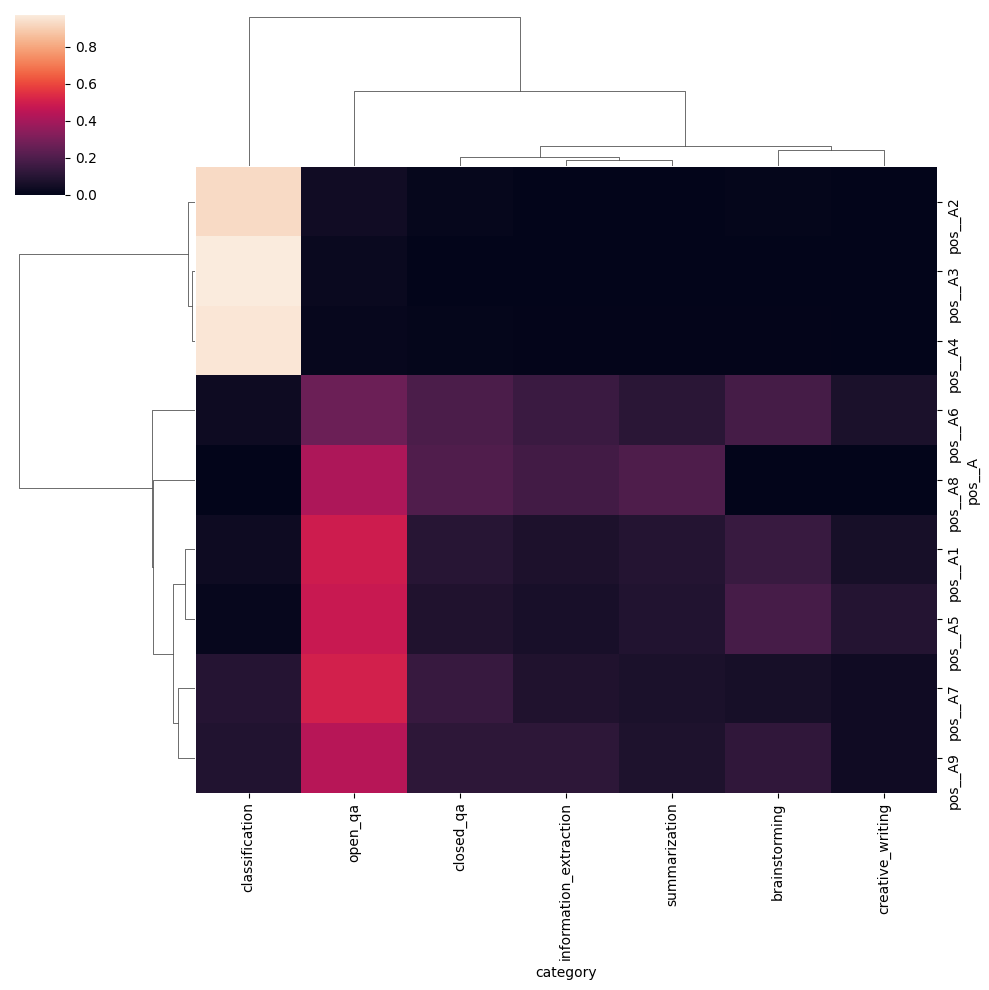

In [20]:
import seaborn as sns
sns.clustermap(pos_xtab_norm) 
# A22, A02, A16, A04, A03, A08, A14 are 95%+ classification, 
# A14 is information extraction
# A07 is 2/3 brainstorming
# A29 is the least informative and largest cluster; I left it out of the Excel file

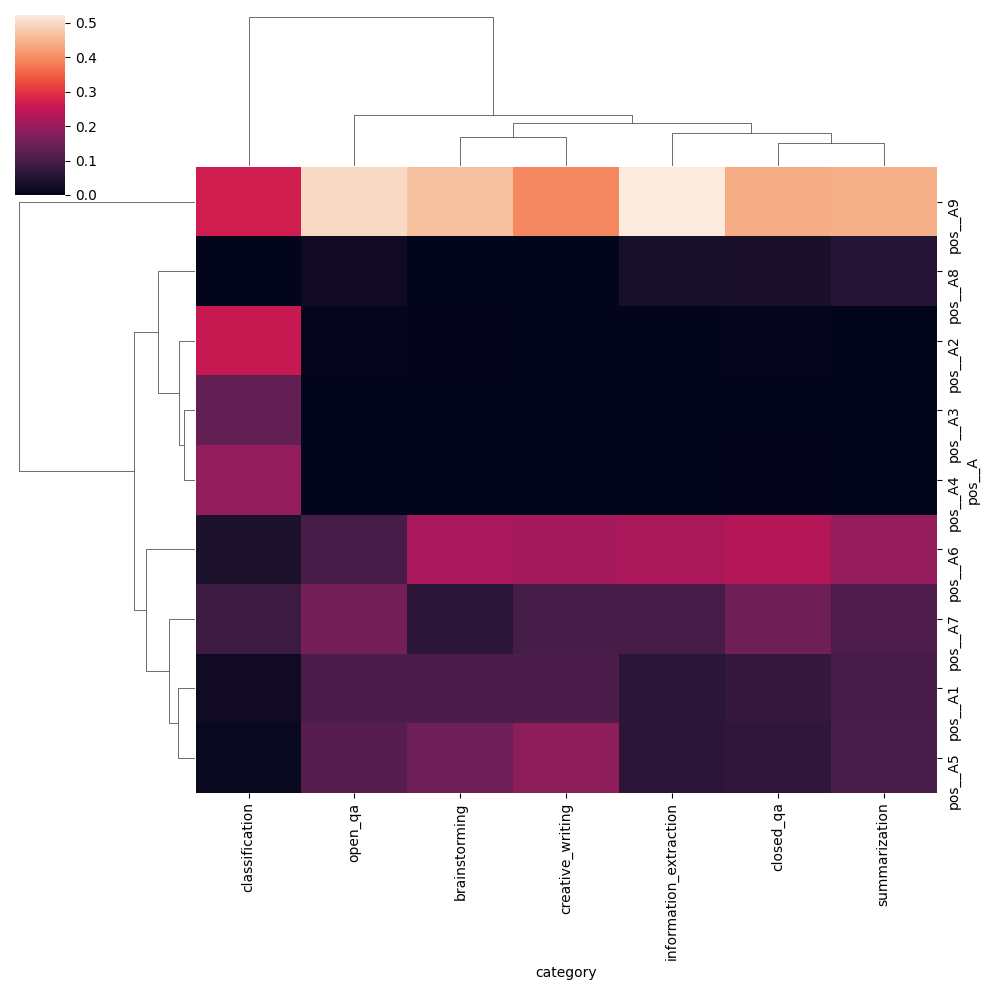

In [21]:
sns.clustermap(pos_xtab.div(pos_xtab.sum(axis=0), axis=1))

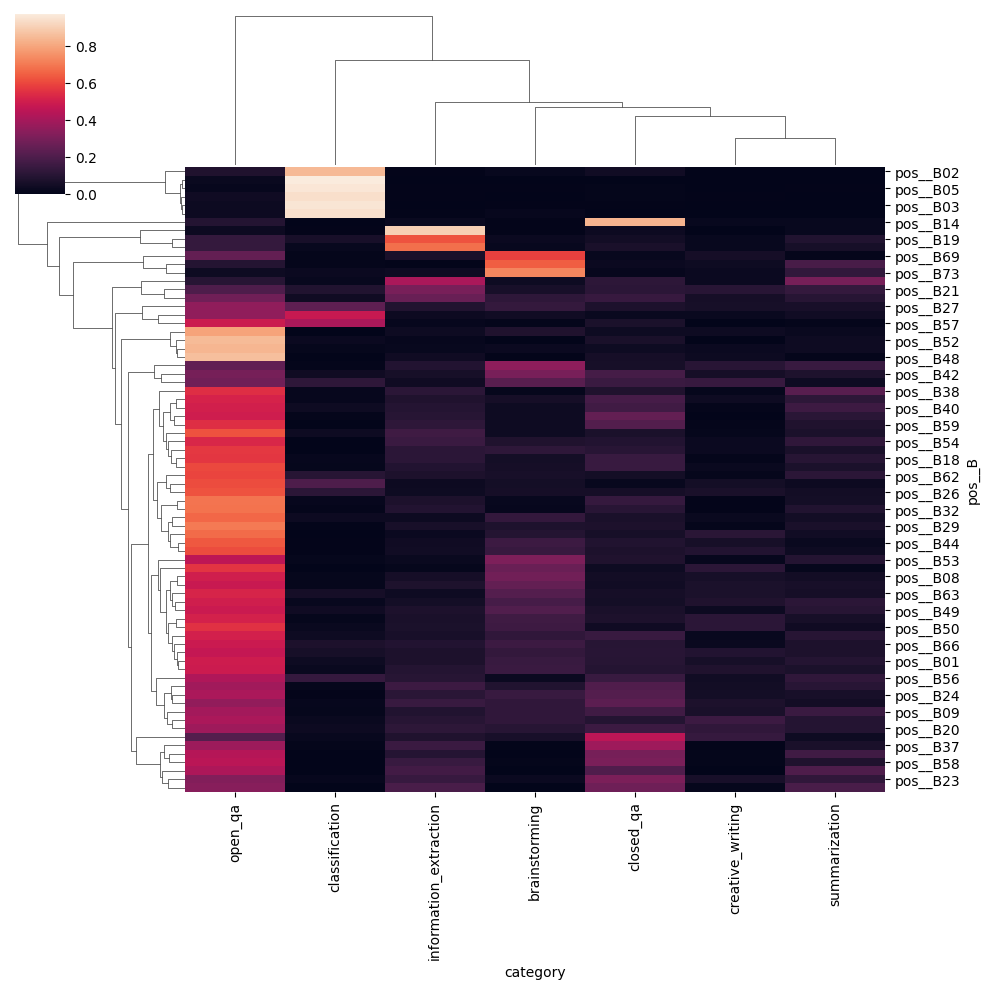

In [22]:
pos_xtab_B = pd.crosstab(dolly_data2['pos__B'], dolly_data2['category'])
pos_xtab_norm_B = pos_xtab_B.div(pos_xtab_B.sum(axis=1), axis=0)
sns.clustermap(pos_xtab_norm_B)
# pos_xtab_norm_B

In [23]:
cluster_cols = [col for col in dolly_data2.columns if 'pos__' in col]
keep_cols = ['instruction', 'instruction_pos', 'category', *cluster_cols]
minidd = dolly_data2[dolly_data2['pos__A'] != 'pos__A29'].sort_values(cluster_cols)[keep_cols]
minidd.to_excel('dolly_data_clustered_by_pos_v2.xlsx')
minidd

,instruction,instruction_pos,category,pos__A,pos__B,pos__C,pos__D,pos__E,pos__F
357,Who are N-Dubz?,pron aux propn noun propn punct,open_qa,pos__A1,pos__B01,pos__C001,pos__D001,pos__E001,pos__F0001
7725,What is Bubble tea?,pron aux propn noun punct,closed_qa,pos__A1,pos__B01,pos__C001,pos__D001,pos__E001,pos__F0001
13700,What is Palmitic acid?,pron aux propn noun punct,open_qa,pos__A1,pos__B01,pos__C001,pos__D001,pos__E001,pos__F0001
12064,What is Detroit style pizza?,pron aux propn noun noun punct,open_qa,pos__A1,pos__B01,pos__C001,pos__D001,pos__E001,pos__F0001
13369,What is Cincinnati style chili?,pron aux propn noun noun punct,information_extraction,pos__A1,pos__B01,pos__C001,pos__D001,pos__E001,pos__F0001
...,...,...,...,...,...,...,...,...,...
4412,"From the given passage, write down some intere...",adp det verb noun punct verb adp det adj noun ...,summarization,pos__A9,pos__B74,pos__C126,pos__D233,pos__E579,pos__F1524
9186,Extract the Greek terms in the following parag...,verb det adj noun adp det verb noun punct adp ...,information_extraction,pos__A9,pos__B74,pos__C126,pos__D233,pos__E579,pos__F1524
3285,"From the following article, tell me the inform...",adp det verb noun punct verb pron det noun ver...,information_extraction,pos__A9,pos__B74,pos__C126,pos__D233,pos__E579,pos__F1524
10375,Extract all unique clubs Suyash played for fro...,verb det adj noun propn verb adp adp det adj n...,information_extraction,pos__A9,pos__B74,pos__C126,pos__D233,pos__E579,pos__F1524


# Predict category from POS N-grams

In [24]:
X = np.asarray( pos_tfidf_matrix.todense() )  # X_tfidf
X.shape  # (15011, 3310)

(15011, 3310)

In [25]:
target_category = 'classification'
flags = [ x==target_category for x in dolly_data['category'] ]

In [26]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# clf = LogisticRegression(C=1, max_iter=10000)
clf = LogisticRegressionCV(cv=5, scoring='roc_auc', n_jobs=-1, max_iter=10000)

# # This takes forever, even using all the cores.
# l1_ratios = [0.01, 0.05, 0.5]
# enet_clf = LogisticRegressionCV(cv=5, penalty='elasticnet', solver='saga', l1_ratios=l1_ratios, scoring='roc_auc', n_jobs=-1, max_iter=10000)

clf.fit(X, flags)

LogisticRegressionCV(cv=5, max_iter=10000, n_jobs=-1, scoring='roc_auc')

In [27]:
scores = clf.predict(X)
fpr, tpr, thresholds = metrics.roc_curve(flags, scores) # pos_label=2
metrics.auc(fpr, tpr) # 0.95295

0.9529558743318425

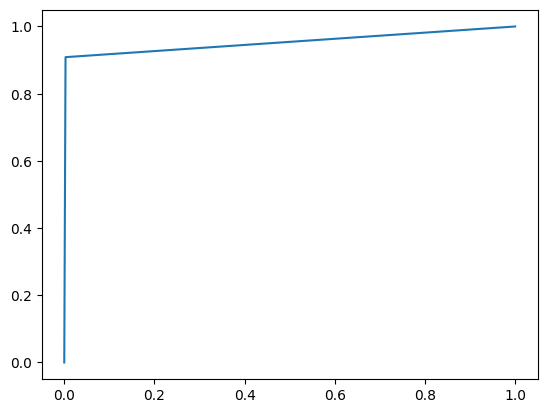

In [28]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)

## Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier  # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, random_state=0)

rf_clf = RandomForestClassifier(n_estimators=500, max_depth=12, min_samples_leaf=20, n_jobs=-1, random_state=0)
rf_clf.fit(X, flags)

scores = rf_clf.predict(X)

fpr, tpr, thresholds = metrics.roc_curve(flags, scores) # pos_label=2
metrics.auc(fpr, tpr)

0.8908852041743937

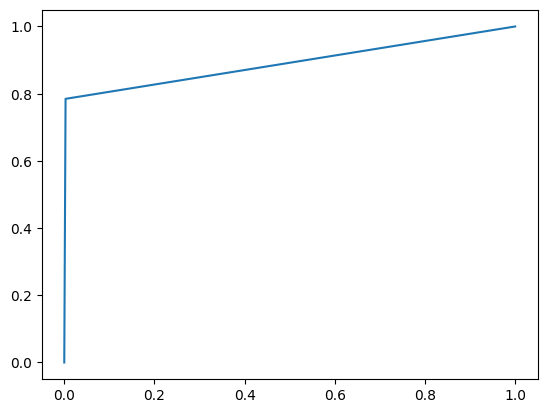

In [30]:
plt.plot(fpr, tpr)

In [31]:
rf_clf.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

In [32]:
# pos_tfidf_matrix.todense()
fi_pdf = pd.DataFrame(
            {'feature': instruction_pos_ngram_counts_pdf.columns,
             'importance': rf_clf.feature_importances_
         })

fi_pdf = fi_pdf[fi_pdf['importance'] > 0.001].reset_index()
fi_pdf

,index,feature,importance
0,26,adj cconj adj punct,0.004368
1,35,adj cconj adj punct propn,0.002488
2,124,adj noun punct noun,0.001201
3,179,adj punct propn punct,0.001993
4,180,adj punct propn punct propn,0.001423
...,...,...,...
181,3149,verb det noun noun aux adj cconj adj punct,0.001935
182,3150,verb det noun noun aux adj cconj adj punct propn,0.002082
183,3151,verb det noun noun aux adj cconj adj punct pro...,0.001336
184,3233,verb pron adp det adj,0.002008


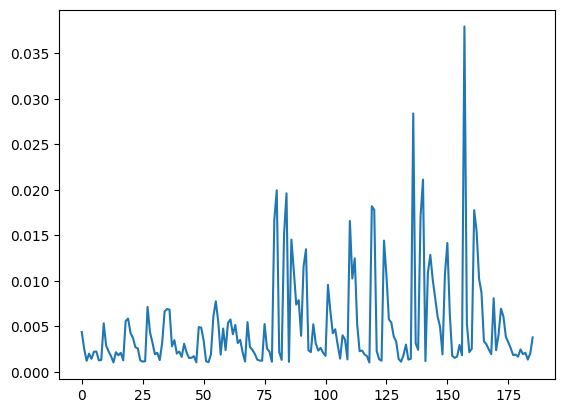

In [33]:
import matplotlib.pyplot as plt
plt.plot(fi_pdf['importance'])

# Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=2, min_samples_leaf=20, random_state=0)
dt_clf.fit(instruction_pos_ngram_counts_pdf, flags)

scores = dt_clf.predict(instruction_pos_ngram_counts_pdf)

fpr, tpr, thresholds = metrics.roc_curve(flags, scores)
metrics.auc(fpr, tpr) # 0.898 for either tfidf or raw counts, max_depth=5; max_depth=12: 0.93 (about as good as it gets)

0.8340862150467255

In [35]:
from sklearn import tree

print(tree.export_text(dt_clf)) # depends only on features [2785, 2652, 465], except it doesn't actually use 465

|--- feature_2785 <= 0.50
|   |--- feature_2652 <= 0.50
|   |   |--- class: False
|   |--- feature_2652 >  0.50
|   |   |--- class: True
|--- feature_2785 >  0.50
|   |--- feature_465 <= 0.50
|   |   |--- class: True
|   |--- feature_465 >  0.50
|   |   |--- class: True



In [36]:
instruction_pos_ngram_counts_pdf.columns[ [2785, 2652, 465] ]

# so the rule is: either 'punct propn punct propn' > 0 or 'punct noun punct noun' > 0

Index(['punct propn punct propn', 'punct noun punct noun',
       'adp propn punct propn punct'],
      dtype='object')

# Engineered features

The fraction of characters that are commas is a really good predictor of classification instructions

0.9529245663794043


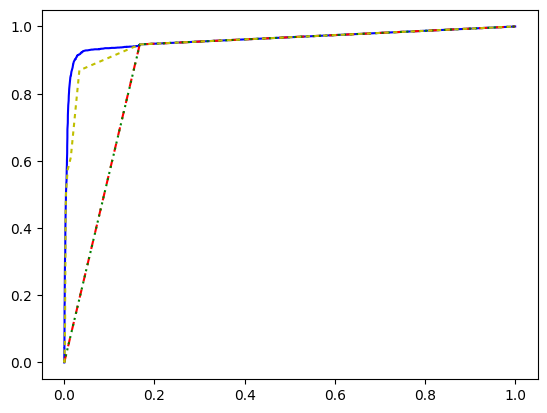

In [44]:
import regex

is_classification = dolly_data['category'] == 'classification'
comma_or_or_fraction = [ ( txt.count(',') + txt.count(' or ') )/len(txt) for txt in dolly_data['instruction'] ] # Somtimes there is no comma, like Banjo or Guitar
has_alternantives_1 = [x > 0 for x in comma_or_or_fraction]
alternatives_pattern = r',|\b(or)\b'
has_alternantives_2 = [ bool(regex.search(alternatives_pattern, txt))for txt in dolly_data['instruction'] ]
comma_or_or_fraction_2 = [ len(regex.findall(alternatives_pattern, txt))for txt in dolly_data['instruction'] ]

fpr, tpr, thresholds = metrics.roc_curve(is_classification, comma_or_or_fraction)
auc = metrics.auc(fpr, tpr) # 0.9129 for commas, 0.9615 for commas or 'or' fraction
plt.plot(fpr, tpr, 'b')

fpr, tpr, thresholds = metrics.roc_curve(is_classification, has_alternantives_1)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'r', dashes=[4, 4])

fpr, tpr, thresholds = metrics.roc_curve(is_classification, has_alternantives_2)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', dashes=[1, 2])

fpr, tpr, thresholds = metrics.roc_curve(is_classification, comma_or_or_fraction_2)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'y', dashes=[2.1])

print(auc)

In [47]:
import re
# is_question = [ bool(re.search(r'\b(Who|What|When|Where|Why|Will|How|Can|Does)\b|\?', x)) for x in dolly_data['instruction'] ]
gives_alternatives = [ bool(re.search(r'\bor\b|,', x)) for x in dolly_data['instruction'] ]
Counter(gives_alternatives)

Counter({False: 10831, True: 4180})

In [49]:
# Percent of each category with 'is_question' flag
is_question_xtab = pd.crosstab(gives_alternatives, dolly_data['category'])
is_question_xtab_norm = is_question_xtab.div(is_question_xtab.sum(axis=0), axis=1)
round(100*is_question_xtab_norm, 1)

category,brainstorming,classification,closed_qa,creative_writing,information_extraction,open_qa,summarization
row_0,,,,,,,
False,91.4,5.3,52.3,77.2,76.2,91.9,86.7
True,8.6,94.7,47.7,22.8,23.8,8.1,13.3


In [52]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

X_tfidf = np.asarray( pos_tfidf_matrix.todense() )

is_question = [ bool(regex.search(r'\?', txt))for txt in dolly_data['instruction'] ]
Counter(is_question) # True: 9180, False: 5831

question_clf = LogisticRegression(C=1, max_iter=10000)
# question_clf = LogisticRegressionCV(cv=5, scoring='roc_auc', n_jobs=-1, max_iter=10000)

question_clf.fit(X_tfidf, is_question)

question_scores = question_clf.predict_proba(X_tfidf)[:,1]

0.7717752844836944
0.7220469289510667


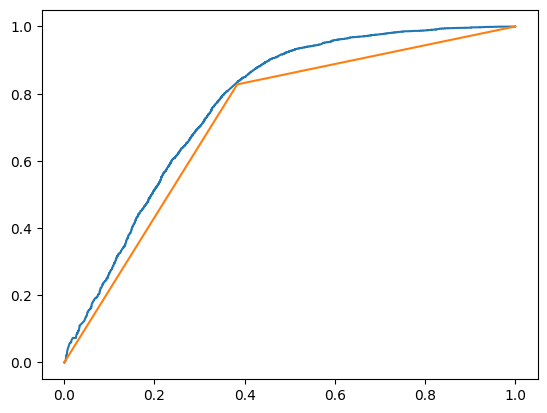

In [54]:
fpr, tpr, thresholds = metrics.roc_curve([ cat in ['open_qa', 'closed_qa'] for cat in dolly_data['category'] ], question_scores)
auc = metrics.auc(fpr, tpr) # 0.9129 for commas, 0.9615 for commas or 'or' fraction
plt.plot(fpr, tpr)
print(auc) # 0.7555431086259887

fpr, tpr, thresholds = metrics.roc_curve([ cat in ['open_qa', 'closed_qa'] for cat in dolly_data['category'] ], [int(q) for q in is_question])
auc = metrics.auc(fpr, tpr) # 0.9129 for commas, 0.9615 for commas or 'or' fraction
plt.plot(fpr, tpr)
print(auc) # 0.7555431086259887

# Predict POS cluster from semantic embedding

In [55]:
dolly_data.columns

Index(['instruction', 'context', 'response', 'category', 'has_context',
       'instruction_vector', 'response_vector', 'instruction_A',
       'instruction_B', 'response_A', 'response_B', 'instruction_pos',
       'pos_tfidf_PCs', 'pos__A', 'pos__B', 'pos__C', 'pos__D', 'pos__E',
       'pos__F'],
      dtype='object')

In [56]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import pickle

CLUSTER_CLASSIFIER_FILE = "pos_cluster_classifiers.pkl"


def fit_cluster_classifier(df, cluster_col, node_name, vector_col='instruction_vector'):
    X = df[vector_col].tolist()
    flags = df[cluster_col] == node_name
    # Counter(flags)[True]
    clf = LogisticRegressionCV(cv=5, scoring='roc_auc', n_jobs=-1, max_iter=10000)
    clf.fit(X, flags)
    return clf


if os.path.exists(CLUSTER_CLASSIFIER_FILE):
    cluster_classifiers = pickle.load(open(CLUSTER_CLASSIFIER_FILE, 'rb'))
else:
    cluster_classifiers = {} # key = node_name, value=fitted classifier
    
    for node_name in popular_nodes['name']:
        if node_name != 'root':
            print(f"Fitting model for '{node_name}'")
            cluster_col = node_name[0:6]
            clf = fit_cluster_classifier(dolly_data, cluster_col, node_name, vector_col='instruction_vector')
            cluster_classifiers[node_name] = clf
    
    pickle.dump(cluster_classifiers, open(CLUSTER_CLASSIFIER_FILE, "wb"))


# scores = clf.predict(X)
# fpr, tpr, thresholds = metrics.roc_curve(flags, scores) # pos_label=2
# metrics.auc(fpr, tpr) # 0.95295

In [57]:
cross_val_mean_auc = {k: np.mean([np.max(v) for v in model.scores_[True]]) for k, model in cluster_classifiers.items()}
cross_val_mean_auc

{'pos__A5': 0.681688347420638,
 'pos__B21': 0.7424481666977527,
 'pos__C042': 0.7321229276551712,
 'pos__A7': 0.8048816812087992,
 'pos__C125': 0.8556334493929192,
 'pos__A4': 0.8309739540980268,
 'pos__B07': 0.7394783161160395,
 'pos__C017': 0.7563789148639684,
 'pos__C029': 0.804393611495815,
 'pos__A2': 0.9541873199844872,
 'pos__B03': 0.9140531590267059,
 'pos__D017': 0.9202767835129368,
 'pos__B59': 0.9629636296314406,
 'pos__C105': 0.9455244758567811,
 'pos__D198': 0.9214742165400127,
 'pos__B29': 0.7446097616054846,
 'pos__B10': 0.8132440430990666,
 'pos__D042': 0.8333361610719118,
 'pos__C054': 0.845155501526795,
 'pos__B38': 0.958704340311264,
 'pos__D168': 0.8476733303341291,
 'pos__B54': 0.8207715066597245,
 'pos__B49': 0.6928585873176368,
 'pos__B09': 0.8513992777273416,
 'pos__B63': 0.8929069330553736,
 'pos__C049': 0.8962134289547684,
 'pos__B66': 0.9469030967567915,
 'pos__B60': 0.8251960314769317,
 'pos__C072': 0.8774468893660725,
 'pos__B17': 0.7733362594879387,
 'pos_

In [62]:
node_id_to_name = { row['id']: row['name'] for row in nodes.to_dict(orient='records') }
parent_dict = { node_id_to_name[row['to']]:  node_id_to_name[ row['from'] ] for row in edges.to_dict(orient='records') }

def path_to_root(node_name, parent_dict):
    current_node = node_name
    path = []
    try:
        while current_node != 'root':
            path.append(current_node.replace('pos__', ''))
            current_node = parent_dict[current_node]
    except:
        path = [f'Oops, no {current_node}']
    return ':'.join(list(reversed(path)))


# path_to_root('pos__E204', parent)
sorted_by_auc = sorted([(path_to_root(node_id, parent_dict), auc) for node_id, auc in cross_val_mean_auc.items()], key=lambda t:t[1], reverse=True)
model_path_auc = {k:v for (k,v) in sorted_by_auc}
model_path_auc

{'A6:B13:C027:D056:E134:F0328': 0.9994688508989598,
 'Oops, no pos__F1527': 0.9992016047611457,
 'A9:B72:C124:D229:E564': 0.9915426839155137,
 'A6:C028:D057:E139': 0.9865934383999768,
 'A6:C025:D048:E117:F0276': 0.9864972085818702,
 'Oops, no pos__E119': 0.9852873492263028,
 'A9:C077:D154:E358:F0920': 0.9781300986123813,
 'Oops, no pos__D234': 0.9773941329420179,
 'A6:B15:C030': 0.9772134693493408,
 'B01:D013:E031:F0074': 0.9762771470395757,
 'A7:B23:C047:D095': 0.975972145450825,
 'B01:C008:E033': 0.9720304775446678,
 'A2:C010:D019:F0102': 0.9714901071735863,
 'Oops, no pos__A3': 0.9670182093436287,
 'A9:B41:C075:D147': 0.9638604535375646,
 'A2:C010:D019': 0.9635915354805842,
 'A7:B23:C046:E234': 0.9634052886296978,
 'B05': 0.9633753172288866,
 'Oops, no pos__D091': 0.9630092062307124,
 'Oops, no pos__B59': 0.9629636296314406,
 'Oops, no pos__D127': 0.9625408197551397,
 'Oops, no pos__C061': 0.9618944614285379,
 'A9:C076:D150:E350': 0.960324525010909,
 'A9:B38': 0.958704340311264,
 'A

<Axes: xlabel='log10_best_C', ylabel='num_big_coef'>

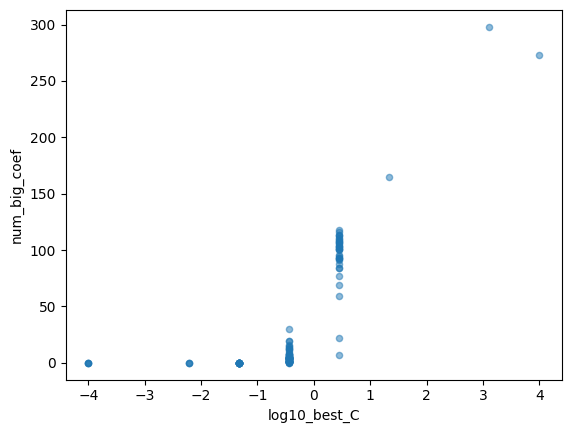

In [63]:
# Does AUC correlate with regularization penalty?

model_info = pd.DataFrame([ {
        'name': node_id, 
        'path': path_to_root(node_id, parent_dict), 
        'best_C': model.C_[0],
        'cross_val_mean_auc': np.mean([np.max(v) for v in model.scores_[True]]),
        'num_big_coef': np.sum( np.abs(model.coef_[0]) > 0.9 )
    }
    for node_id, model in cluster_classifiers.items()])

model_info['log10_best_C'] = np.log10(model_info['best_C'])

model_info.plot.scatter(x='log10_best_C', y='num_big_coef', alpha=0.5)

<Axes: xlabel='num_big_coef', ylabel='cross_val_mean_auc'>

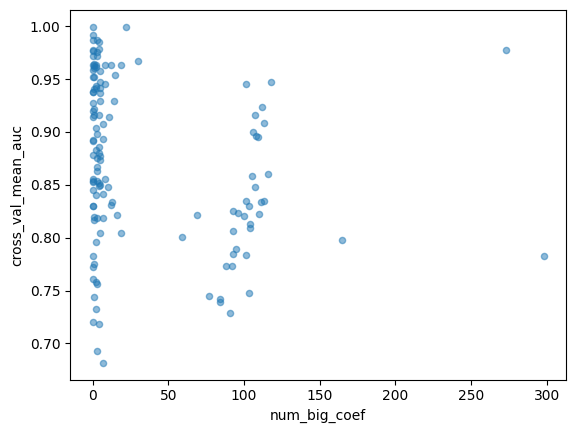

In [64]:
model_info.plot.scatter(x='num_big_coef', y='cross_val_mean_auc', alpha=0.5)

<Axes: xlabel='log10_best_C', ylabel='cross_val_mean_auc'>

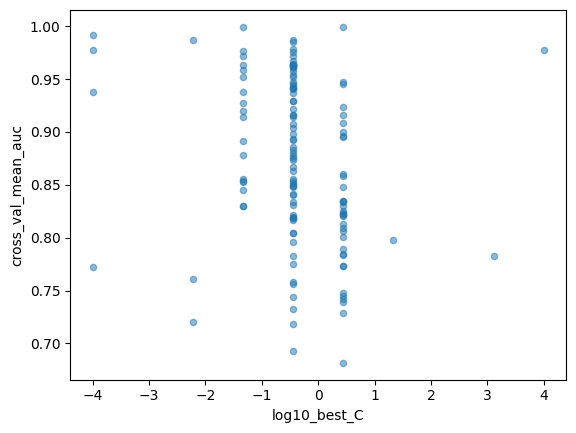

In [65]:
model_info.plot.scatter(x='log10_best_C', y='cross_val_mean_auc', alpha=0.5)

In [66]:
M_coef = pd.DataFrame([model.coef_[0] for node_id, model in cluster_classifiers.items()]).transpose()
M_coef.columns = [path_to_root(node_id, parent_dict) for node_id in cluster_classifiers.keys()]

good_predictors = [ col for col in M_coef.columns if model_path_auc[col] > 0.95 ]
good_predictors

['A2',
 'Oops, no pos__B59',
 'A9:B38',
 'Oops, no pos__A3',
 'A7:B23:C047:D095',
 'A7:B23:C046:E234',
 'A7:B30:C060',
 'B01:C008:E033',
 'B01:D013:E031:F0074',
 'Oops, no pos__D091',
 'Oops, no pos__C061',
 'Oops, no pos__D127',
 'B05',
 'A9:B41:C075:D147',
 'A9:C076:D150:E350',
 'A2:C010:D019',
 'A2:C010:D019:F0102',
 'Oops, no pos__D234',
 'A6:B15:C030',
 'A6:C028:D057:E139',
 'A6:B13:C027:D056:E134:F0328',
 'A9:B72:C124:D229:E564',
 'Oops, no pos__F1527',
 'A2:C010:D019:F0098',
 'A9:C077:D154:E358:F0920',
 'Oops, no pos__E119',
 'A6:C025:D048:E117:F0276',
 'Oops, no pos__F1531']

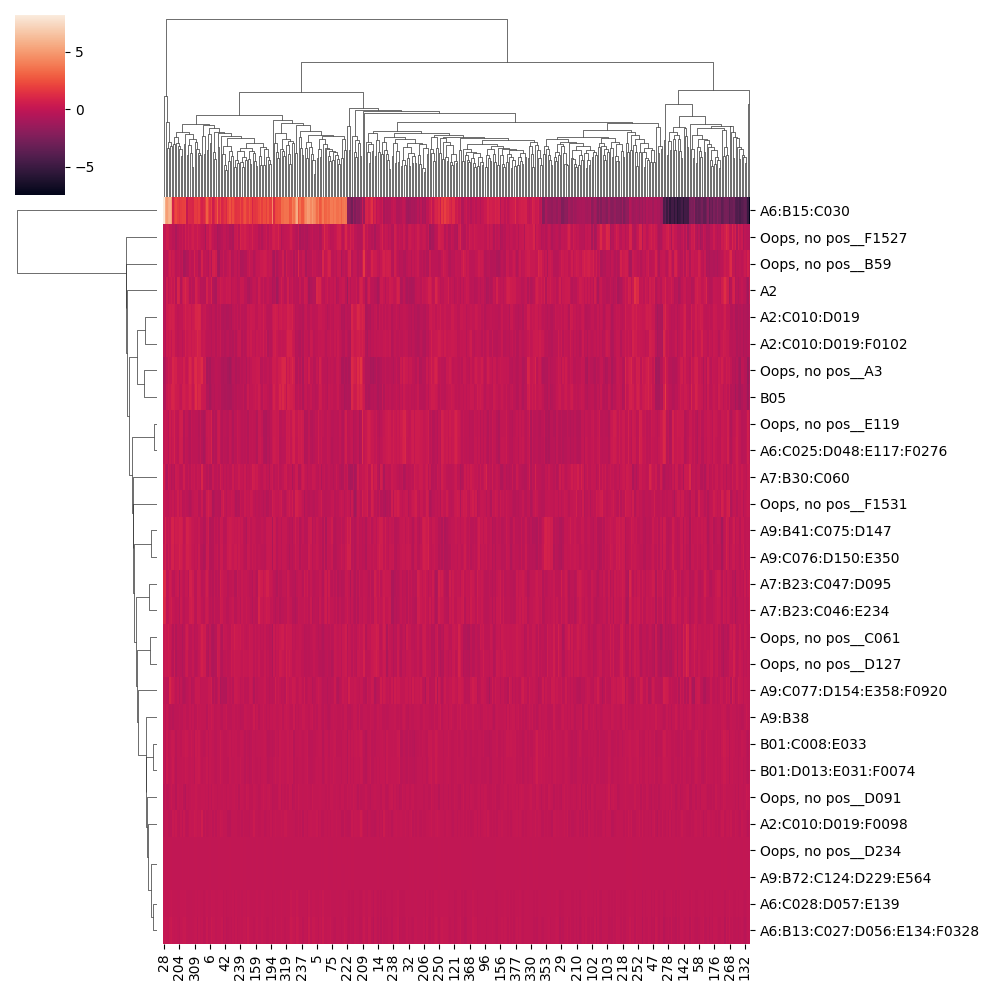

In [67]:
sns.clustermap(M_coef[good_predictors].transpose(), figsize=(10, 10), method='average', metric='euclidean') # default method and metric

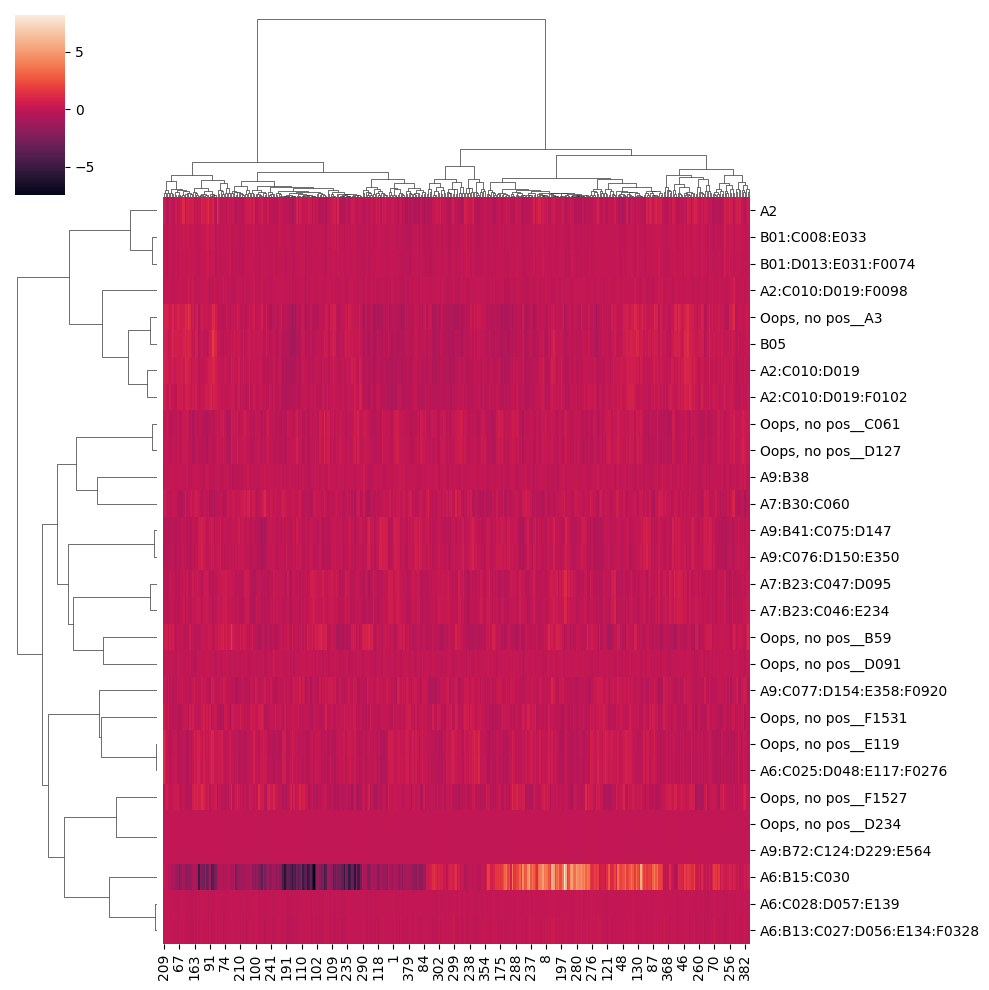

In [68]:
sns.clustermap(M_coef[good_predictors].transpose(), figsize=(10, 10), metric='cosine', method='ward')

In [ ]:
sns.clustermap(M_coef[good_predictors].transpose(), figsize=(10, 10), #metric='cosine', method='ward', 
               standard_scale=1)

In [ ]:
dolly_data2.to_parquet("dolly_pos_clusters.parquet")